# Comparación de muestras: Geométrica (Teórica vs Transformada Integral)

En este ejercicio generamos dos muestras de `Geom(p)` de tamaño `N`:
- **Muestra teórica**: generada con `scipy.stats.geom.rvs` (distribución geométrica con soporte {1,2,...}).
- **Muestra empírica**: generada por el método de la transformada integral (inversa de la CDF sobre uniformes).

Comparamos ambas muestras mediante la prueba de Kolmogorov-Smirnov (dos muestras) y una prueba Chi-cuadrado de dos muestras (discreta). Nivel de significancia: α = 0.05.

In [1]:
# Imports y configuración de gráficos
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Parámetros
N = 10000  # tamaño de muestra (ajusta si quieres)
p = 0.2   # parámetro de la geométrica (probabilidad de éxito)
seed = 42
rng = np.random.default_rng(seed)

In [3]:
# Generar la muestra teórica (scipy) y la empírica (transformada integral)
# scipy.stats.geom.rvs usa la parametrización con probabilidad p y soporte {1,2,...}
muestra_teorica = stats.geom.rvs(p, size=N, random_state=seed)

# Transformada integral inversa: k = ceil( log(1-u) / log(1-p) ) donde u~Unif(0,1)
u = rng.random(N)
muestra_empirica = np.ceil(np.log(1 - u) / np.log(1 - p)).astype(int)

# Verificar

In [4]:
# Estadísticos descriptivos básicos
def describe_sample(x, name):
    print(f"=== {name} ===")
    print('N =', len(x))
    print('Min =', np.min(x), 'Max =', np.max(x))
    print('Mean =', np.mean(x))
    print()

describe_sample(muestra_teorica, 'Muestra Teórica (scipy)')
describe_sample(muestra_empirica, 'Muestra Empírica (Transformada Integral)')

=== Muestra Teórica (scipy) ===
N = 10000
Min = 1 Max = 37
Mean = 4.9007

=== Muestra Empírica (Transformada Integral) ===
N = 10000
Min = 1 Max = 48
Mean = 4.9741



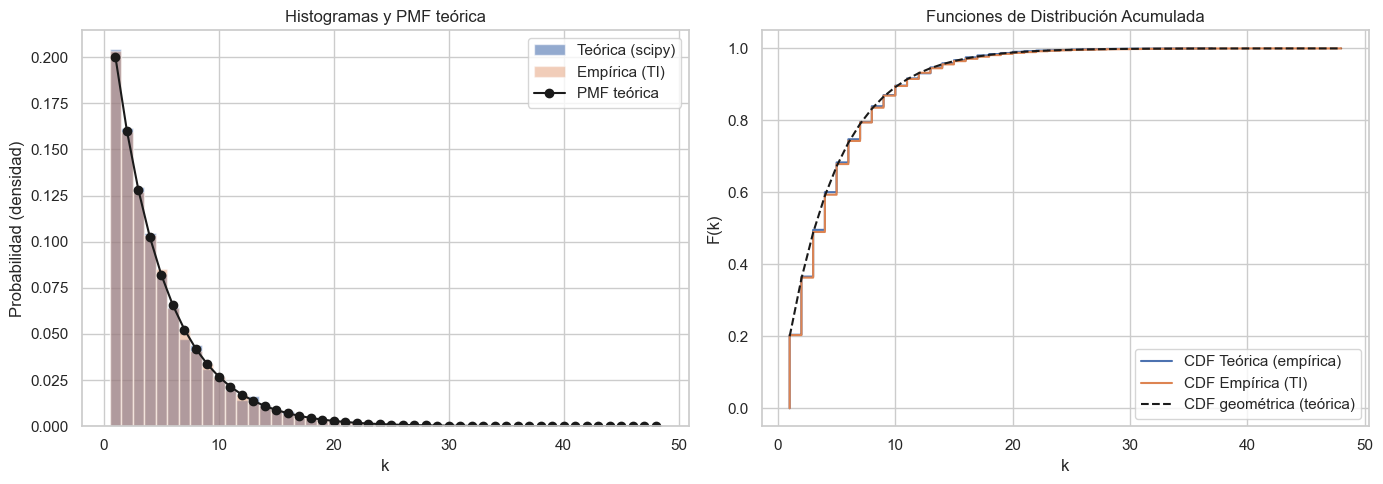

In [5]:
# Histogramas y PMF comparada
fig, axes = plt.subplots(1, 2, figsize=(14,5))
# Histograma de muestras (barras por entero)
max_k = max(muestra_teorica.max(), muestra_empirica.max(), 20)
bins = np.arange(0.5, max_k + 1.5, 1)
axes[0].hist(muestra_teorica, bins=bins, alpha=0.6, density=True, label='Teórica (scipy)')
axes[0].hist(muestra_empirica, bins=bins, alpha=0.4, density=True, label='Empírica (TI)')
# PMF teórica superpuesta
ks = np.arange(1, max_k+1)
pmf = stats.geom.pmf(ks, p)
axes[0].plot(ks, pmf, 'ko-', label='PMF teórica')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Probabilidad (densidad)')
axes[0].set_title('Histogramas y PMF teórica')
axes[0].legend()

# CDF empírica vs CDF teórica
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/len(xs)
    return xs, ys
xt, yt = ecdf(muestra_teorica)
xe, ye = ecdf(muestra_empirica)
axes[1].step(xt, yt, where='post', label='CDF Teórica (empírica)')
axes[1].step(xe, ye, where='post', label='CDF Empírica (TI)')
# CDF teórica analytica
x_theory = np.arange(1, max_k+1)
cdf_theory = stats.geom.cdf(x_theory, p)
axes[1].plot(x_theory, cdf_theory, 'k--', label='CDF geométrica (teórica)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('F(k)')
axes[1].set_title('Funciones de Distribución Acumulada')
axes[1].legend()
plt.tight_layout()
plt.show()

In [6]:
# Prueba de Kolmogorov-Smirnov (dos muestras)
ks_stat, ks_p = stats.ks_2samp(muestra_teorica, muestra_empirica)
print('KS two-sample statistic =', ks_stat, ', p-value =', ks_p)
if ks_p > 0.05:
    print('Conclusión KS: No se rechaza H0 -> las muestras pueden provenir de la misma distribución (α=0.05)')
else:
    print('Conclusión KS: Se rechaza H0 -> las muestras NO provienen de la misma distribución (α=0.05)')

KS two-sample statistic = 0.007 , p-value = 0.967081996278138
Conclusión KS: No se rechaza H0 -> las muestras pueden provenir de la misma distribución (α=0.05)


In [7]:
# Prueba Chi-Cuadrado (dos muestras discretas)
def chi2_two_sample(sample1, sample2):
    # contar ocurrencias por valor entero
    min_k = min(sample1.min(), sample2.min())
    max_k = max(sample1.max(), sample2.max())
    ks = np.arange(min_k, max_k+1)
    obs1 = np.array([np.sum(sample1 == k) for k in ks])
    obs2 = np.array([np.sum(sample2 == k) for k in ks])
    n1 = len(sample1)
    n2 = len(sample2)
    combined = obs1 + obs2
    # Esperados bajo H0 (misma distribución): proporción combinada
    exp1 = combined * (n1 / (n1 + n2))
    exp2 = combined * (n2 / (n1 + n2))
    # Filtrar categorías con expecteds < 5 (requisito chi2)
    valid = (exp1 >= 5) & (exp2 >= 5)
    obs1_v = obs1[valid]
    obs2_v = obs2[valid]
    exp1_v = exp1[valid]
    exp2_v = exp2[valid]
    chi2 = np.sum((obs1_v - exp1_v)**2/exp1_v) + np.sum((obs2_v - exp2_v)**2/exp2_v)
    df = len(obs1_v) - 1
    p_val = 1 - stats.chi2.cdf(chi2, df)
    return chi2, df, p_val, ks[valid] if len(ks[valid])>0 else ks

chi2_stat, chi2_df, chi2_p, ks_valid = chi2_two_sample(muestra_teorica, muestra_empirica)
print('Chi2 =', chi2_stat, ' df =', chi2_df, ' p-value =', chi2_p)
if chi2_p > 0.05:
    print('Conclusión Chi2: No se rechaza H0 -> las muestras pueden provenir de la misma distribución (α=0.05)')
else:
    print('Conclusión Chi2: Se rechaza H0 -> las muestras NO provienen de la misma distribución (α=0.05)')

Chi2 = 21.907312918516748  df = 27  p-value = 0.742072221379967
Conclusión Chi2: No se rechaza H0 -> las muestras pueden provenir de la misma distribución (α=0.05)


## Conclusión (interpretación)

**Resumen de resultados:**
- Tamaño de las muestras: N = 10,000 (ambas).
- Estadísticos: media teórica = 4.9007, media empírica = 4.9741 (diferencia = 0.0734).
- Pruebas estadísticas realizadas (α = 0.05):
  - Kolmogorov–Smirnov (dos muestras): estadístico = 0.007, p = 0.9671 → No se rechaza H0.
  - Chi-cuadrado (dos muestras, categorías con expected ≥ 5): Chi2 = 21.9073, df = 27, p = 0.7421 → No se rechaza H0.

**Interpretación:**
Ambas pruebas devuelven p-values mucho mayores que el nivel de significancia (0.05). Esto implica que no existe evidencia estadística suficiente para afirmar que las dos muestras provienen de distribuciones distintas. La diferencia observada en las medias es pequeña y consistente con variabilidad de muestreo. En conjunto con las inspecciones visuales (histogramas, PMF y CDFs), concluimos que la muestra generada por la transformada integral es estadísticamente equivalente a la generada por `scipy.stats.geom` para `Geom(p)` con p = 0.2 en este experimento.